<a href="https://colab.research.google.com/github/stephaneNiyonizigiye/ML-AI_models/blob/main/trading_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Stephane Niyonizigiye 300242927<br/>


# LSTM model - RNN

**version 2**

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline


Data fetch and model trainning

    Data fetch

In [ ]:
# Fonction pour récupérer les données boursières
def fetch_stock_data(symbol, start_date, end_date):
    print(f"Fetching data for {symbol} from {start_date} to {end_date}...")
    data = yf.download(symbol, start=start_date, end=end_date)
    if data.isna().sum().sum() > 0:
        data.dropna(inplace=True)
    print(data.head())
    return data

    Adding Technical indicator to the data




In [ ]:
# Fonction pour ajouter des indicateurs techniques
def add_technical_indicators(data):
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['RSI'] = 100 - (100 / (1 + (data['Close'].diff(1).clip(lower=0).rolling(window=14).mean() /
                                     (-data['Close'].diff(1).clip(upper=0).rolling(window=14).mean()))))
    data.bfill(inplace=True)
    return data


    Data preparation

In [ ]:
# Fonction pour préparer les données pour LSTM
def prepare_data(data, window_size=50):
    features = data[['Close', 'SMA_20', 'RSI']].values
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    X, y = [], []

    for i in range(window_size, len(features_scaled)):
        X.append(features_scaled[i-window_size:i])
        y.append(features_scaled[i, 0])  # La colonne "Close" est la cible

    X, y = np.array(X), np.array(y)
    return X, y, scaler

    Building LSTM model
    

In [ ]:
# Fonction pour construire le modèle de base
def build_base_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(units=100, return_sequences=True),
        LSTM(units=50, return_sequences=False),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


    model trainning and saving

In [ ]:

# Fonction pour entraîner et sauvegarder le modèle de base
def train_base_model(symbols, start_date, end_date, window_size=50):
    all_data = []
    for symbol in symbols:
        print(f"\n\n Processing {symbol}...\n")
        data = fetch_stock_data(symbol, start_date, end_date)

        data = add_technical_indicators(data)
        X, y, _ = prepare_data(data, window_size)
        all_data.append((X, y))
    # Combiner toutes les données
    X_all = np.concatenate([d[0] for d in all_data], axis=0)
    y_all = np.concatenate([d[1] for d in all_data], axis=0)

    # Diviser les données
    X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

    # Construire et entraîner le modèle
    model = build_base_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])

    # Sauvegarder le modèle
    model.save("/content/drive/MyDrive/AI models/base_model2.keras")
    print("\n\n Base model saved as 'base_model2.keras'.")
    return model


# Étape principale
if __name__ == "__main__":
    # Entraîner le modèle de base
    symbols = ["AAPL", "MSFT", "TSLA"]
    train_base_model(symbols, start_date="2020-01-01", end_date="2022-12-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



 Processing AAPL...

Fetching data for AAPL from 2020-01-01 to 2022-12-31...
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.716072  72.776598  71.466812  71.721019  135480400
2020-01-03  72.009117  72.771745  71.783962  71.941328  146322800
2020-01-06  72.582901  72.621639  70.876068  71.127858  118387200
2020-01-07  72.241547  72.849224  72.021231  72.592594  108872000
2020-01-08  73.403641  73.706271  71.943751  71.943751  132079200


 Processing MSFT...

Fetching data for MSFT from 2020-01-01 to 2022-12-31...
Price            Close        High         Low        Open    Volume
Ticker            MSFT        MSFT        MSFT        MSFT      MSFT
Date                                                                
2020-01-02  153.323257  153.428261  151.137295  151.566850  22622100
2020-01-03  151.414154  152.683736  15


[*********************100%***********************]  1 of 1 completed




 Processing TSLA...

Fetching data for TSLA from 2020-01-01 to 2022-12-31...
Price           Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                             
2020-01-02  28.684000  28.713333  28.114000  28.299999  142981500
2020-01-03  29.534000  30.266666  29.128000  29.366667  266677500
2020-01-06  30.102667  30.104000  29.333332  29.364668  151995000
2020-01-07  31.270666  31.441999  30.224001  30.760000  268231500
2020-01-08  32.809334  33.232666  31.215334  31.580000  467164500
Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0372 - val_loss: 0.0030
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - 

Fine tunning process


In [ ]:
!pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 8.6 MB/s eta 0:00:00


Fetching data for AAPL from 2023-01-01 to 2024-12-31...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2023-01-03  123.632523  129.395510  122.742865  128.782641  112117500
2023-01-04  124.907700  127.181268  123.642412  125.431607   89113600
2023-01-05  123.583092  126.301485  123.326085  125.668841   80962700
2023-01-06  128.130219  128.792516  123.454587  124.561717   87754700
2023-01-09  128.654114  131.876655  128.397108  128.970443   70790800
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.2190e-04 - val_loss: 3.9688e-04
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.6822e-04 - val_loss: 3.0314e-04
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.7553e-04 - val_loss: 3

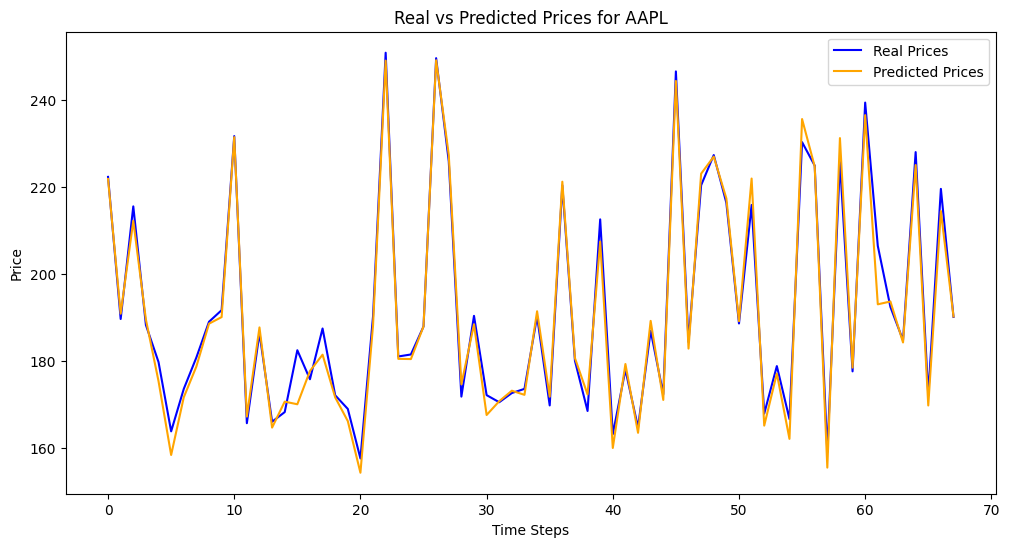

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf
from sklearn.model_selection import train_test_split

def calculate_sharpe_ratio(returns, risk_free_rate=0.02):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

def calculate_sortino_ratio(returns, risk_free_rate=0.02):
    downside_returns = returns[returns < risk_free_rate]
    downside_std = np.std(downside_returns) if len(downside_returns) > 0 else 1e-6
    return np.mean(returns - risk_free_rate) / downside_std

def calculate_max_drawdown(prices):
    peak = np.maximum.accumulate(prices)
    drawdown = (prices - peak) / peak
    return np.min(drawdown)

def calculate_annualized_return(total_return, n_years):
    return (1 + total_return) ** (1 / n_years) - 1

def fine_tune_model(model_path, symbol, start_date, end_date, window_size=50):
    data = fetch_stock_data(symbol, start_date, end_date)
    data = add_technical_indicators(data)
    X, y, scaler = prepare_data(data, window_size)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    model = load_model(model_path)
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stopping])

    test_loss = model.evaluate(X_test, y_test)
    print(f"Fine-tuned Test Loss for {symbol}: {test_loss}")

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 2)))))[:, 0]
    y_test = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2)))))[:, 0]

    returns = np.diff(predictions) / predictions[:-1]
    sharpe = calculate_sharpe_ratio(returns)
    sortino = calculate_sortino_ratio(returns)
    max_drawdown = calculate_max_drawdown(predictions)
    annual_return = calculate_annualized_return(np.sum(returns), n_years=(len(y_test) / 252))

    print(f"Sharpe Ratio: {sharpe:.4f}")
    print(f"Sortino Ratio: {sortino:.4f}")
    print(f"Max Drawdown: {max_drawdown:.4f}")
    print(f"Annualized Return: {annual_return:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Real Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='orange')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.title(f'Real vs Predicted Prices for {symbol}')
    plt.show()

if __name__ == "__main__":
    fine_tune_model("/content/drive/MyDrive/AI models/base_model2.keras", symbol="AAPL", start_date="2023-01-01", end_date="2024-12-31")


# Real Time

**Real time**

In [ ]:
#This part of Code is an extra to the project ... I didn't include it in the project description

In [ ]:
!pip install alpaca-trade-api

Potential trading bot

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from alpaca_trade_api.rest import REST, TimeFrame
from google.colab import userdata


# Configuration de l'API Alpaca
API_KEY = userdata.get('APCA-API-KEY-ID')
API_SECRET = userdata.get('APCA-API-SECRET-KEY')
BASE_URL = 'https://paper-api.alpaca.markets'  # Mode paper trading

# Initialisation de l'API
api = REST(API_KEY, API_SECRET, BASE_URL, api_version='v2')

# Charger le modèle fine-tuné
model = load_model("/content/drive/MyDrive/AI models/base_model2.h5")
model.compile(optimizer='adam', loss='mean_squared_error')  # Recompiler le modèle


# Fonction pour récupérer les données en temps réel
def fetch_live_data(symbol, lookback=50):
    try:
        # Récupérer un plus grand nombre de données si nécessaire
        bars = api.get_bars(symbol, TimeFrame.Minute, limit=lookback + 60)  # +10 pour compenser les données manquantes
        data = pd.DataFrame([{
            "timestamp": bar.t,
            "open": bar.o,
            "high": bar.h,
            "low": bar.l,
            "close": bar.c,
            "volume": bar.v,
        } for bar in bars])

        # Calcul des indicateurs techniques
        data['SMA_20'] = data['close'].rolling(window=20).mean()
        data['RSI'] = 100 - (100 / (1 + (data['close'].diff(1).clip(lower=0).rolling(window=14).mean() /
                                         (-data['close'].diff(1).clip(upper=0).rolling(window=14).mean()))))
        data.dropna(inplace=True)

        # Vérifier si suffisamment de données existent pour une prédiction
        if len(data) < lookback:
            print("Pas assez de données après traitement des indicateurs.")
            return None

        return data
    except Exception as e:
        print(f"Erreur lors de la récupération des données : {e}")
        return None

# Normalisation et prédictions
def predict_next_price(data, model):
    scaler = MinMaxScaler()
    features = data[['close', 'SMA_20', 'RSI']].values
    features_scaled = scaler.fit_transform(features)
    X_input = np.array([features_scaled[-50:]])  # Fenêtre glissante
    prediction = model.predict(X_input)
    predicted_price = scaler.inverse_transform([[prediction[0][0], 0, 0]])[0][0]
    return predicted_price

# Exécuter un ordre de trading
def execute_trade(symbol, action, qty):
 url = "https://paper-api.alpaca.markets/v2/orders"

 payload = {
      "side": "buy",
      "type": "market",
      "time_in_force": "day"
  }
 headers = {
      "accept": "application/json",
      "content-type": "application/json",
      "APCA-API-KEY-ID": "PKB2O8EKNHHUSKD9G89L",
      "APCA-API-SECRET-KEY": "nzg8bbUcpdXSlY7zx4FlOeA7iFcz0T5TeftEmcGa"
  }
 response = requests.post(url, json=payload, headers=headers)

# Stratégie de trading avec stop-loss et take-profit
def trading_strategy(symbol, model, qty=1, stop_loss=0.02, take_profit=0.05):
    print(f"Starting trading for {symbol} with Stop-Loss: {stop_loss*100}%, Take-Profit: {take_profit*100}%...")
    position_price = None
    while True:
        try:
            # Récupérer les données en temps réel
            data = fetch_live_data(symbol)
            if data is None or len(data) < 50:
                print("Pas assez de données pour une prédiction.")
                time.sleep(60)
                continue

            # Faire une prédiction
            predicted_price = predict_next_price(data, model)
            current_price = data['close'].iloc[-1]

            print(f"Prix actuel : {current_price}, Prix prédit : {predicted_price}")

            # Gestion des règles de stop-loss et take-profit
            if position_price:
                if current_price <= position_price * (1 - stop_loss):
                    print("Stop-Loss atteint. Vendre la position.")
                    execute_trade(symbol, "sell", qty)
                    position_price = None
                    continue

                if current_price >= position_price * (1 + take_profit):
                    print("Take-Profit atteint. Vendre la position.")
                    execute_trade(symbol, "sell", qty)
                    position_price = None
                    continue

            # Générer un signal d'achat
            if predicted_price > current_price * 1.01 and position_price is None:
                print("Signal : ACHAT")
                execute_trade(symbol, "buy", qty)
                position_price = current_price

            time.sleep(60)

        except Exception as e:
            print(f"Erreur : {e}")
            time.sleep(60)


# Lancer la stratégie
if __name__ == "__main__":
    symbol = "NVDA"  # Symbole à trader


    #tradding strategy
    trading_strategy(symbol, model, qty=1, stop_loss=0.02, take_profit=0.05)


Trading request through the API

In [ ]:
import requests



# URL de l'API Paper Trading
url = "https://paper-api.alpaca.markets/v2/orders"

# Détails de l'ordre
payload = {
    "symbol": "AAPL",  # Symbole de l'action
    "qty": 1,          # Quantité à acheter
    "side": "buy",      # Côté (achat ou vente)
    "type": "market",   # Type d'ordre (market, limit, etc.)
    "time_in_force": "day"  # Validité de l'ordre
}

# En-têtes avec clés API
headers = {
    "accept": "application/json",
    "content-type": "application/json",
    "APCA-API-KEY-ID": API_KEY,
    "APCA-API-SECRET-KEY": API_SECRET
}

# Envoyer la requête POST pour passer l'ordre
response = requests.post(url, json=payload, headers=headers)

# Afficher la réponse
print(response.status_code)
print(response.json())


200
{'id': 'bbba23da-9694-4c6d-ac36-ac8b7b6a0248', 'client_order_id': 'd877025f-493e-4c22-91b9-3dbf5fd3dcb4', 'created_at': '2024-12-24T15:31:35.374777985Z', 'updated_at': '2024-12-24T15:31:35.375454615Z', 'submitted_at': '2024-12-24T15:31:35.374777985Z', 'filled_at': None, 'expired_at': None, 'canceled_at': None, 'failed_at': None, 'replaced_at': None, 'replaced_by': None, 'replaces': None, 'asset_id': 'b0b6dd9d-8b9b-48a9-ba46-b9d54906e415', 'symbol': 'AAPL', 'asset_class': 'us_equity', 'notional': None, 'qty': '1', 'filled_qty': '0', 'filled_avg_price': None, 'order_class': '', 'order_type': 'market', 'type': 'market', 'side': 'buy', 'position_intent': 'buy_to_open', 'time_in_force': 'day', 'limit_price': None, 'stop_price': None, 'status': 'pending_new', 'extended_hours': False, 'legs': None, 'trail_percent': None, 'trail_price': None, 'hwm': None, 'subtag': None, 'source': None, 'expires_at': '2024-12-24T18:00:00Z'}
